In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from scipy.stats import ks_2samp, chisquare,  power_divergence

import tmap, os
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem

#from map4 import MAP4Calculator, to_mol

import matplotlib.pyplot as plt
%matplotlib inline
tqdm.pandas(ascii=True)
np.random.seed(123)

def GetJacarrdD(tmlf, VectorUint1, VectorUint2):  
    
    M = len(VectorUint1)
    N = len(VectorUint2)
    Jacarrd_d =[]   
    for fp1 in tqdm(VectorUint1, ascii=True):
        for fp2 in VectorUint2:
            s = tmlf.get_distance(fp1, fp2)
            Jacarrd_d.append(s)

    Jacarrd_d = np.array(Jacarrd_d)
    return Jacarrd_d.reshape(M, N)

RDKit WARNING: [15:09:15] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
dim = 1024
n_clusters = 5

In [3]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
#https://reneshbedre.github.io/blog/chisq.html#-chi-square-%CF%872-test-for-independence-pearson-chi-square-test

from chembench import dataset
data = dataset.load_ClinTox()  #load_ESOL, load_Lipop, load_Malaria, load_PDBF, load_HIV, load_BACE,load_BBBP

total samples: 1478


In [4]:
task_name = data.task_name

In [5]:
data_save_folder = './cluster_split_results/%s' % task_name

if not os.path.exists(data_save_folder):
    os.makedirs(data_save_folder)

In [6]:
mols = [Chem.MolFromSmiles(s) for s in data.x]
ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,dim) for x in tqdm(mols, ascii=True)]
ecfps = [tmap.VectorUchar(list(fp)) for fp in ECFP4_fps]
enc = tmap.Minhash(dim,seed = 42)

lf = tmap.LSHForest(dim)
lf.batch_add(enc.batch_from_binary_array(ecfps))
lf.index()

# # # Calculate the MAP4 fp
# calc = MAP4Calculator(dimensions=dim)
# fps = calc.calculate_many([to_mol(s) for s in data.x])


# # # Calculate the MHFP
# # # enc = MHFPEncoder(dim)
# # # fps = [tmap.VectorUint(enc.encode(s)) for s in data.x]

# # Initialize the LSH Forest
# lf = tmap.LSHForest(dim)

# # Add the Fingerprints to the LSH Forest and index
# lf.batch_add(fps)
# lf.index()

100%|##########| 1478/1478 [00:00<00:00, 29094.99it/s]


In [7]:
# # # Calculate the MAP4 fp
# calc = MAP4Calculator(dimensions=dim)
# fps = calc.calculate_many([to_mol(s) for s in data.x])


# # # Calculate the MHFP
# # # enc = MHFPEncoder(dim)
# # # fps = [tmap.VectorUint(enc.encode(s)) for s in data.x]

# # Initialize the LSH Forest
# lf = tmap.LSHForest(dim)

# # Add the Fingerprints to the LSH Forest and index
# lf.batch_add(fps)
# lf.index()

In [43]:
x, y, s, t, gp = tmap.layout_from_lsh_forest(lf)
X = np.array([x,y]).T

def adj_list_to_matrix(adj_list):
    n = len(adj_list)
    adj_matrix = np.zeros((n,n))
    for i,c in enumerate(adj_list):
        for (j, weight) in c:
            adj_matrix[i, j] = weight    
    return adj_matrix

adj_csr = adj_list_to_matrix(gp.adjacency_list)

clustering  = AgglomerativeClustering(n_clusters = n_clusters, connectivity = adj_csr,).fit(X)
# clustering= SpectralClustering(n_clusters = n_clusters, random_state = 2, n_init = 100).fit(X)
dft = pd.concat([pd.Series(clustering.labels_), pd.Series(x)], axis=1)
order_dict = dft.groupby(0)[1].apply(np.min).sort_values().argsort().to_dict()

clustering.labels_ = pd.Series(clustering.labels_).map(order_dict).values

pd.Series(clustering.labels_).value_counts()

/home/shenwanxiang/.local/lib/python3.6/site-packages/sklearn/cluster/_agglomerative.py:246: UserWarning: the number of connected components of the connectivity matrix is 52 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


4    394
0    311
1    305
2    268
3    200
dtype: int64

In [44]:
mapd = {}
for k, v in pd.Series(clustering.labels_ + 1).value_counts().items():
    mapd.update({k:'%s(%s)'% (k,v)})
    
branch_name = 'Group'

if data.y.shape[1] > 1:
    task_name = data.y_cols[0]
    
df = data.df  
df = pd.DataFrame(data.y[:, 0], columns = [task_name])
df[branch_name]= (clustering.labels_ + 1)
df['TMAP1'] = x
df['TMAP2'] = y
df[branch_name] = df[branch_name].map(mapd)

df['smiles'] = data.x
df[[branch_name]].to_pickle(os.path.join(data_save_folder, 'cluster_split_%s.idx' % task_name))

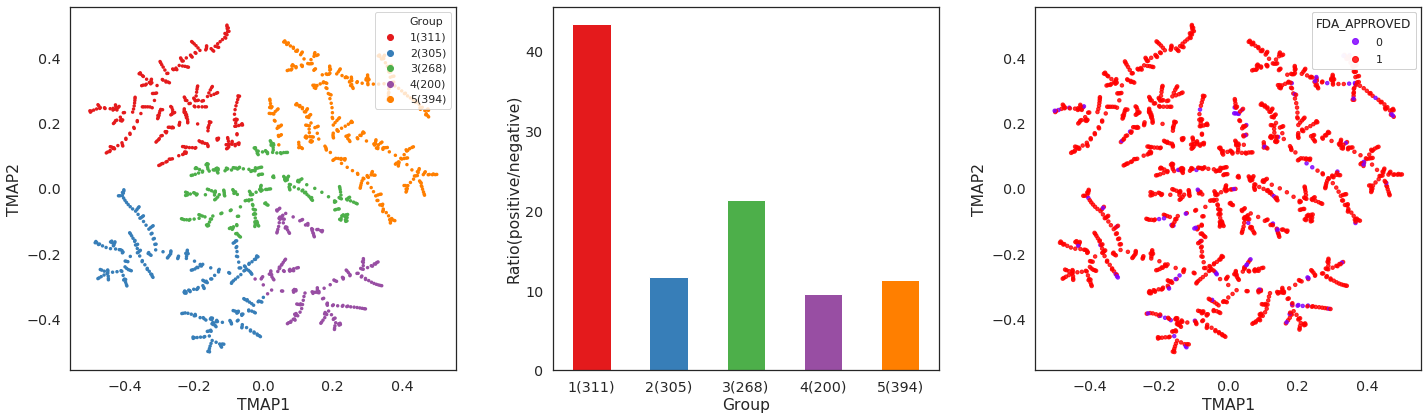

In [52]:
sns.set(style='white', font_scale = 1.3)
size = 12
palette = sns.color_palette("Set1", n_clusters)

order = df[branch_name].unique()
order.sort()

fig, axes = plt.subplots(ncols=3,figsize=(20,6))
ax1, ax2, ax3 = axes


sns.set(style="white")

_ = sns.scatterplot('TMAP1', 'TMAP2',  hue = branch_name, palette = palette,  hue_order = order, s = size,
                    data = df, ax = ax1, linewidth = 0)
ax1.legend(loc='upper right')

if data.task_type == 'regression':
    num = 6
    _ = sns.catplot(x = branch_name, y = task_name,  kind="swarm",  palette = palette,order = order, data=df, ax= ax2 , )

else:
    num = 1
    gb = df.groupby([branch_name, task_name]).size().unstack()
    gb.columns = gb.columns.astype(int)
#     _ = gb.plot(kind='bar', stacked = True, cmap = 'rainbow', ax= ax2)
    gbb = gb[1]/gb[0]
    gbb.plot(kind = 'bar', color = palette, ax= ax2, rot=0)
    ax2.set_ylabel('Ratio(positive/negative)')


    
im3 = ax3.scatter(x = df.TMAP1, y = df.TMAP2, alpha = .8, c = df[task_name].tolist(), cmap = 'rainbow', s = size)
ax3.set_xlabel('TMAP1')
ax3.set_ylabel('TMAP2')

# fig.colorbar(im, ax=ax3)

lg3 = ax3.legend(*im3.legend_elements(num = num), loc="upper right", title=task_name,)
ax3.add_artist(lg3)


# fig.tight_layout()
fig.show()
plt.close(2)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

fig.savefig(os.path.join(data_save_folder, '%s.png' % task_name), dpi=300, format='png')
fig.savefig(os.path.join(data_save_folder, '%s.pdf' % task_name), dpi=300, format='pdf')

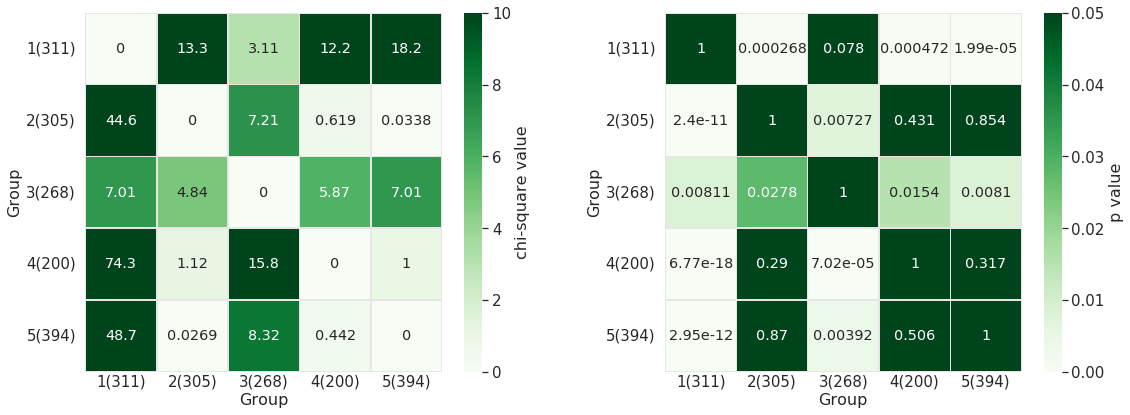

In [46]:
sns.set(style='white', font_scale = 1.2)
fig, axes = plt.subplots(ncols=2,figsize=(16,6))
ax1, ax2,  = axes

fontsize = 16

if data.task_type == 'regression':

    gb = df.groupby('Group')[task_name].apply(lambda x:x.values)
    ks_values = []
    p_values = []
    for i in gb.index:
        for j in gb.index:
            expected = gb.loc[i]
            observed = gb.loc[j]
            ks, p = ks_2samp(expected, observed)
            ks_values.append(ks)
            p_values.append(p)
    arrv = np.array(ks_values).reshape(len(gb), len(gb)).astype('float16')
    arrp = np.array(p_values).reshape(len(gb), len(gb))
    dfv = pd.DataFrame(arrv, index = gb.index, columns = gb.index)
    dfp = pd.DataFrame(arrp, index = gb.index, columns = gb.index)    

    vax = sns.heatmap(dfv, annot=True, cmap = 'Greens', fmt='.3g',  ax = ax1,
                     linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'KS value'})
    vax.figure.axes[-1].yaxis.label.set_size(fontsize)
    vax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size
    
    pax = sns.heatmap(dfp, vmax = 0.05, annot=True, cmap = 'Greens', fmt='.3g',  ax= ax2,
                     linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'p value', })
    
    pax.figure.axes[-1].yaxis.label.set_size(fontsize)
    pax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size
    
else:
    
    gb = df.groupby([branch_name, task_name]).size().unstack()
    gb.columns = gb.columns.astype(int)
    
    chisq_values = []
    p_values = []
    for i in gb.index:
        for j in gb.index:
            expected = gb.loc[i].values
            observed = gb.loc[j].values
            # adjust the number of the expected
            expected_adjust = (expected / expected.sum()) * observed.sum()

            chisq, p = chisquare(expected_adjust, observed)
            chisq_values.append(chisq)
            p_values.append(p)

    arrv = np.array(chisq_values).reshape(len(gb), len(gb)).astype('float16')
    arrp = np.array(p_values).reshape(len(gb), len(gb))
    dfv = pd.DataFrame(arrv, index = gb.index, columns = gb.index)
    dfp = pd.DataFrame(arrp, index = gb.index, columns = gb.index)

    vax = sns.heatmap(dfv, vmax = 10, annot=True, cmap = 'Greens', fmt='.3g',  ax = ax1,
                     linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'chi-square value'})
    vax.figure.axes[-1].yaxis.label.set_size(fontsize)
    vax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size
    
    pax = sns.heatmap(dfp, vmax = 0.05, annot=True, cmap = 'Greens', fmt='.3g',  ax= ax2,
                     linewidths  = 0.5, linecolor='0.9', cbar_kws={'label': 'p value',})
    pax.figure.axes[-1].yaxis.label.set_size(fontsize)
    pax.collections[0].colorbar.ax.tick_params(labelsize=15) #cbar ticklabel size    

    
for ax in [ax1, ax2]:
    ax.set_yticklabels(dfv.index, rotation=0, fontsize="15", va="center")
    ax.set_xticklabels(dfv.index, rotation=0, fontsize="15", va="center")
    ax.axhline(y=0, color='0.9',lw= 0.5, ls =  '--')
    ax.axhline(y=dfv.shape[0], color='0.9',lw= 0.5, ls =  '--')
    ax.autoscale()
    ax.axvline(x=dfv.shape[1], color='0.9',lw= 0.5, ls =  '--')  
    ax.axvline(x=0, color='0.9',lw= 0.5, ls =  '--')
    ax.set_xlabel('Group', fontsize = 16)
    ax.set_ylabel('Group', fontsize = 16)

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

fig.savefig(os.path.join(data_save_folder, '%s_stat_test.png' % task_name), dpi=300, format='png')
fig.savefig(os.path.join(data_save_folder, '%s_stat_test.pdf' % task_name), dpi=300, format='pdf')

dfv['Value'] = 'statistic value'
dfv = dfv.reset_index().set_index(['Value', 'Group'])
dfp['Value'] = 'p value'
dfp = dfp.reset_index().set_index(['Value', 'Group'])
dfv.append(dfp).to_excel(os.path.join(data_save_folder, '%s_stat_test.xlsx' % task_name))

In [47]:
data.y.shape

(1478, 2)

In [48]:
# Now plot interactive results

if data.task_type == 'regression':
    categorical=[False, True,]
else:
    categorical = [True, True,]
    
faerun = Faerun(view="front", clear_color='#111111',coords=False) #'#ffffff'
faerun.add_scatter(
    task_name,
    {   "x": x, 
        "y": y, 
        "c": [data.y[:, 0], clustering.labels_],
        "labels": data.x},
    point_scale=5,
    colormap = ['rainbow', 'Set1'],
    has_legend=True,
    categorical = categorical,
    series_title = [task_name, branch_name],
    legend_labels = [None,  [(i, "%s" % (i+1)) for i in range(n_clusters)]],
    shader = 'smoothCircle'
)

faerun.add_tree(task_name + "_tree", {"from": s, "to": t}, point_helper=task_name,  color='#666666', ) #colors when no value

# Choose the "smiles" template to display structure on hover
faerun.plot(task_name, path = data_save_folder, template="smiles", notebook_height=750)

/home/shenwanxiang/Research/ChemBench/chembench/robustness/cluster_split/cluster_split_results/ClinTox/FDA_APPROVED.html